In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import re
from utils import *
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.metrics import homogeneity_score
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("data/U.S._Chronic_Disease_Indicators__CDI_.csv")
df.head()

,YearStart,YearEnd,LocationAbbr,LocationDesc,DataSource,Topic,Question,Response,DataValueUnit,DataValueType,...,LocationID,TopicID,QuestionID,DataValueTypeID,StratificationCategoryID1,StratificationID1,StratificationCategoryID2,StratificationID2,StratificationCategoryID3,StratificationID3
0,2015,2015,US,United States,APIS,Alcohol,Amount of alcohol excise tax by beverage type ...,NaN,$,US Dollars,...,59,ALC,ALC8_0_2,USD,OVERALL,OVR,NaN,NaN,NaN,NaN
1,2012,2012,DC,District of Columbia,APIS,Alcohol,Amount of alcohol excise tax by beverage type ...,NaN,$,US Dollars,...,11,ALC,ALC8_0_1,USD,OVERALL,OVR,NaN,NaN,NaN,NaN
2,2012,2012,GU,Guam,APIS,Alcohol,Amount of alcohol excise tax by beverage type ...,NaN,$,US Dollars,...,66,ALC,ALC8_0_1,USD,OVERALL,OVR,NaN,NaN,NaN,NaN
3,2012,2012,PR,Puerto Rico,APIS,Alcohol,Amount of alcohol excise tax by beverage type ...,NaN,$,US Dollars,...,72,ALC,ALC8_0_1,USD,OVERALL,OVR,NaN,NaN,NaN,NaN
4,2012,2012,US,United States,APIS,Alcohol,Amount of alcohol excise tax by beverage type ...,NaN,$,US Dollars,...,59,ALC,ALC8_0_1,USD,OVERALL,OVR,NaN,NaN,NaN,NaN


# Keep only the unique questions

In [3]:
df = df[~df.duplicated("Question", keep="first")][["Topic", "Question"]].reset_index(drop=True)
df.head()

,Topic,Question
0,Alcohol,Amount of alcohol excise tax by beverage type ...
1,Alcohol,Amount of alcohol excise tax by beverage type ...
2,Alcohol,Amount of alcohol excise tax by beverage type ...
3,"Nutrition, Physical Activity, and Weight Status",Obesity among adults aged >= 18 years
4,Cardiovascular Disease,Hospitalization for heart failure among Medica...


# Extracting keywords from questions using tf-idf

In [4]:
tfidf = TfidfVectorizer()
csr_matrix  = tfidf.fit_transform(df["Question"])
csr_matrix.shape

(203, 409)

In [5]:
def extract_keywords(idx):
    feature_names = tfidf.get_feature_names()
    feature_index = csr_matrix[idx,:].nonzero()[1]
    tfidf_scores = zip(feature_index, [csr_matrix[idx, x] for x in feature_index])
    return [(feature_names[i], s) for (i, s) in tfidf_scores]

In [6]:
df["Keywords"] = [extract_keywords(i) for i in range(len(df))]
df

,Topic,Question,Keywords
0,Alcohol,Amount of alcohol excise tax by beverage type ...,"[(wine, 0.4095746295825765), (type, 0.35910407..."
1,Alcohol,Amount of alcohol excise tax by beverage type ...,"[(beer, 0.4095746295825765), (type, 0.35910407..."
2,Alcohol,Amount of alcohol excise tax by beverage type ...,"[(spirits, 0.37901626981453873), (distilled, 0..."
3,"Nutrition, Physical Activity, and Weight Status",Obesity among adults aged >= 18 years,"[(years, 0.2776929334166198), (18, 0.334157310..."
4,Cardiovascular Disease,Hospitalization for heart failure among Medica...,"[(65, 0.2728132043629712), (persons, 0.3535593..."
...,...,...,...
198,"Nutrition, Physical Activity, and Weight Status",Farmers markets that accept Women and Infant C...,"[(coupons, 0.28623934360489744), (market, 0.28..."
199,Oral Health,Population served by community water systems t...,"[(fluoridated, 0.28457063160978424), (optimall..."
200,"Nutrition, Physical Activity, and Weight Status",Presence of regulations pertaining to serving ...,"[(vegetables, 0.3557043157246686), (settings, ..."
201,Oral Health,Dental visits among children and adolescents a...,"[(17, 0.43840710700446456), (adolescents, 0.43..."


In [7]:
def keywords_from_group(group):
    keywords = {}
    for lst in group["Keywords"]:
        for keyword, score in lst:
            if keyword in keywords:
                keywords[keyword] += score
            else:
                keywords[keyword] = score
    return pd.Series(keywords).sort_values(ascending=False)

In [8]:
words = df.groupby("Topic").apply(keywords_from_group).to_frame().rename(columns={0: "Score"})
words = words.rename_axis(["Topic", "Keyword"])
words

Score
Topic   Keyword             
Alcohol drinking    3.058039
        binge       2.945476
        alcohol     2.611974
        among       1.479489
        18          1.254690
...                      ...
Tobacco population  0.208108
        proportion  0.196638
        all         0.187741
        by          0.174325
        with        0.154771

[731 rows x 1 columns]

In [9]:
words.to_csv("data/tfidfweights.csv")

# Breakdown of questions' topics

In [10]:
topics = df["Topic"].value_counts()
topics

Nutrition, Physical Activity, and Weight Status    37
Cancer                                             20
Diabetes                                           20
Cardiovascular Disease                             18
Chronic Obstructive Pulmonary Disease              16
Overarching Conditions                             16
Tobacco                                            16
Alcohol                                            16
Arthritis                                          10
Asthma                                              9
Oral Health                                         9
Older Adults                                        4
Chronic Kidney Disease                              4
Reproductive Health                                 3
Mental Health                                       3
Immunization                                        1
Disability                                          1
Name: Topic, dtype: int64

# Filter out categories with few entries

In [11]:
df = df[df["Topic"].str.match("|".join(topics.nlargest(11).index.to_list()))].reset_index(drop=True)
df.head()

,Topic,Question,Keywords
0,Alcohol,Amount of alcohol excise tax by beverage type ...,"[(wine, 0.4095746295825765), (type, 0.35910407..."
1,Alcohol,Amount of alcohol excise tax by beverage type ...,"[(beer, 0.4095746295825765), (type, 0.35910407..."
2,Alcohol,Amount of alcohol excise tax by beverage type ...,"[(spirits, 0.37901626981453873), (distilled, 0..."
3,"Nutrition, Physical Activity, and Weight Status",Obesity among adults aged >= 18 years,"[(years, 0.2776929334166198), (18, 0.334157310..."
4,Cardiovascular Disease,Hospitalization for heart failure among Medica...,"[(65, 0.2728132043629712), (persons, 0.3535593..."


# Project tf-idf weights onto 2d space

In [12]:
tfidf = TfidfVectorizer()
csr_matrix  = tfidf.fit_transform(df["Question"])
csr_matrix.shape

(187, 383)

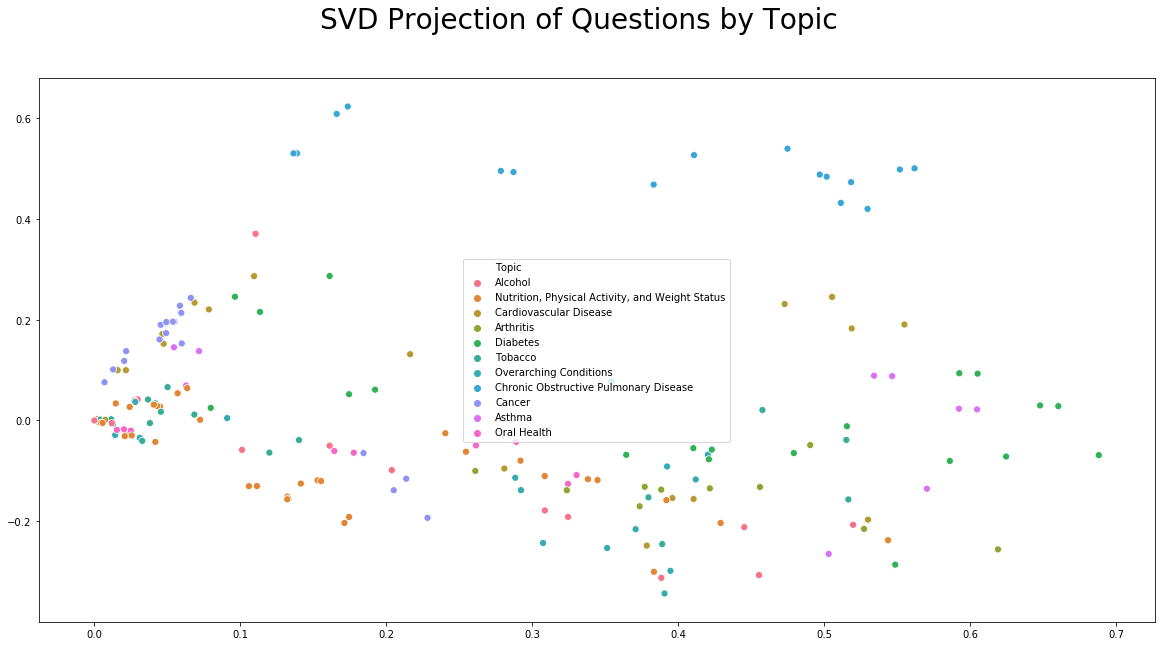

In [13]:
coords = TruncatedSVD(n_components=2).fit_transform(csr_matrix)
fig = plt.figure(figsize=(20, 10))
fig.suptitle("SVD Projection of Questions by Topic", fontsize=28)
sns.scatterplot(coords[:,0], coords[:,1], hue=df["Topic"], s=50, cmap=plt.cm.Spectral)

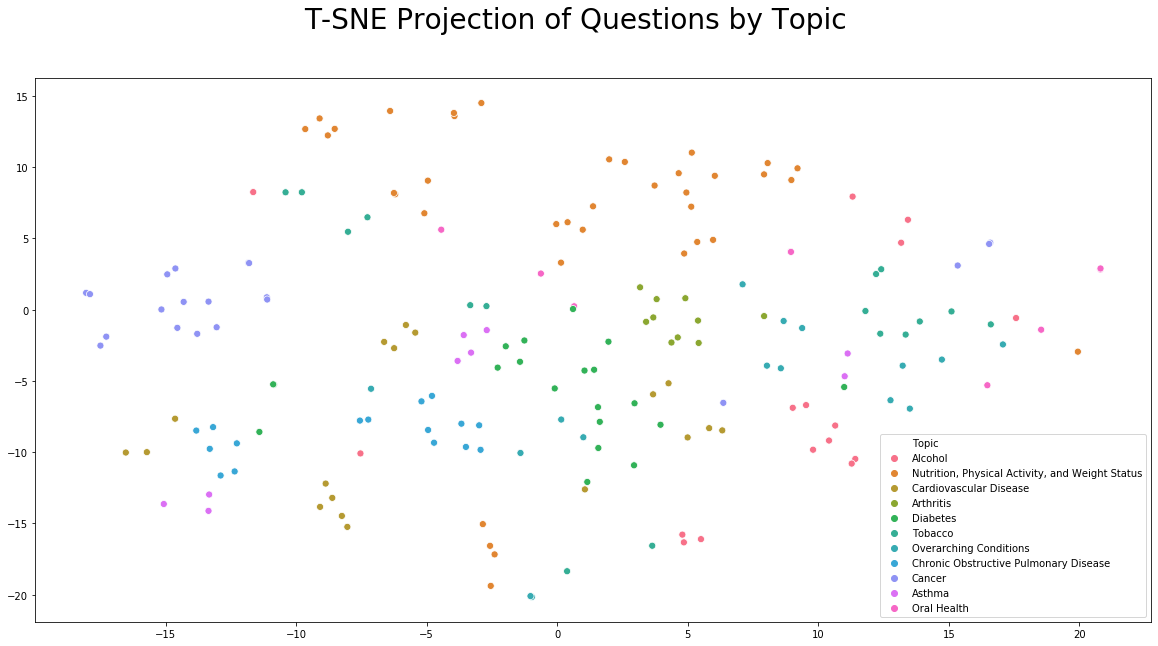

In [14]:
coords = TSNE(n_components=2).fit_transform(csr_matrix.todense())
fig = plt.figure(figsize=(20, 10))
fig.suptitle("T-SNE Projection of Questions by Topic", fontsize=28)
sns.scatterplot(coords[:,0], coords[:,1], hue=df["Topic"], s=50, cmap=plt.cm.Spectral)

# Evaluatin